In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow import keras

In [5]:
SEED = 155
np.random.seed(SEED)

# IMPORT DO DATASET X
x = pd.read_csv("C:/Users/User/Desktop/UFPA/TCC/dados/dataset_non_norm_TCC.csv")
x = x.loc[:, ~x.columns.str.contains('^Unnamed')].to_numpy()

# IMPORT DO DATASET Y OR LABELS
dados = pd.read_csv("C:/Users/User/Desktop/UFPA/TCC/dados/LEMPS_LDWSS_12345678_TOP_Rotulos.csv")
'''
for i in range(0,dados['label'].count()):
  j = dados['label'][i]
  if (j == 3 or j == 4 or j == 6 or j == 7 or j == 8):
    dados['label'][i] = 5 

for i in range(0,dados['label'].count()):
  j = dados['label'][i]
  if (j == 2):
    dados['label'][i] = 1

for i in range(0,dados['label'].count()):
  j = dados['label'][i]
  if (j == 5):
    dados['label'][i] = 2

    
for i in range(0,dados['label'].count()):
  j = dados['label'][i]
  if (j == 1):
    dados['label'][i] = 0

    
for i in range(0,dados['label'].count()):
  j = dados['label'][i]
  if (j == 2):
    dados['label'][i] = 1'''
    

y = dados['label'].to_numpy()
names = ['-CG', '+CG', '-CID', '+CID', 'IC', 'PB', 'RPT', 'CPT']

In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# LABEL ENCODER => FROM [1, 2, ... , 8]  TO  [0, 1, ... , 7]
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

# ONE HOT ENCONDING
dummy_y = np_utils.to_categorical(encoded_y)

In [10]:
encoded_y

array([0, 0, 0, ..., 7, 7, 7], dtype=int64)

In [11]:
dummy_y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [12]:
from sklearn.model_selection import train_test_split

# SPLIT INTO TRAIN AND TEST SUBSETS 
x_train, x_test, y_train, y_test = train_test_split(x, dummy_y,
                                                    test_size=0.2)


In [13]:
from imblearn.over_sampling import SMOTE

# APPLYING SMOTE ONLY TO THE TRAINING SUBSET
smote = SMOTE(random_state = 42)
x_sm_train, y_sm_train = smote.fit_resample(x_train, y_train)

x_train = x_sm_train
y_train = y_sm_train

In [14]:
# RESHAPING EACH SUBSET TO FIT INTO THE INPUT LAYER
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))


In [15]:
num_classes = len(np.unique(encoded_y))

In [16]:
# RANDOMIZING THE SUBSET'S ORDERS 
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [17]:
# BULDING THE BASIC RESISUAL BLOCK FOR LATER USE
def residual_block(input_layer):
    # INPUT LAYER
    merge_input = input_layer
    
    # FIRTS CONVLUTION
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=8, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    
    # SECOND CONVOLUTION
    conv2 = keras.layers.Conv1D(filters=128, kernel_size=5, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    
    # THIRD CONVOLUTION
    conv3 = keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(conv2)
    # ADDING THE RESISUE AND THEN PASSING THROUGH BN AND RELU
    layer_out = keras.layers.add([conv3, merge_input])
    layer_out = keras.layers.BatchNormalization()(layer_out)
    layer_out = keras.layers.ReLU()(layer_out)
    
    return layer_out
    
    

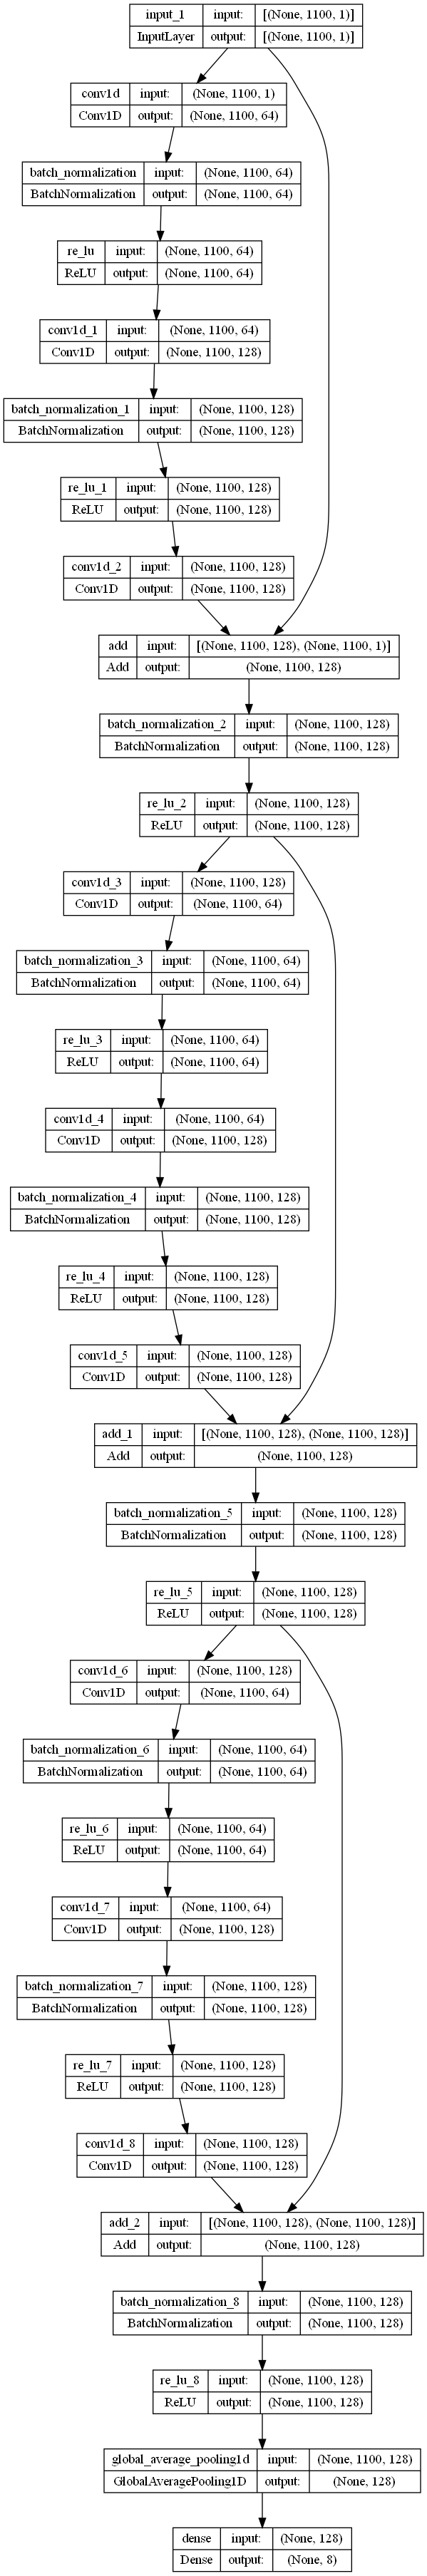

In [18]:
# BULDING THE MODEL WITH THE BASIC RESIDUAL BLOCK
def make_model(input_shape):
    # INPUT LAYER
    input_layer = keras.layers.Input(input_shape)
    
    # FIRST RESIDUAL BLOCK
    X = residual_block(input_layer)
    # SECOND RESIDUAL BLOCK
    X = residual_block(X)
    # THIRD RESIDUAL BLOCK
    X = residual_block(X)
    
    # PASSING THROUGH A GAP LAYER
    gap = keras.layers.GlobalAveragePooling1D()(X)

    # FINAL CLASSIFICATION DENSE LAYER
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [19]:
'''model = keras.Sequential(
    [
    keras.layers.Input(shape = x_train.shape[1:]),

    keras.layers.Conv1D(filters=16, kernel_size=32, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
        
    keras.layers.Conv1D(filters=32, kernel_size=16, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
        
    keras.layers.GlobalAveragePooling1D(),
        
    keras.layers.Dense(num_classes, activation="softmax")
        
    ]
)

keras.utils.plot_model(model, show_shapes=True)'''

'model = keras.Sequential(\n    [\n    keras.layers.Input(shape = x_train.shape[1:]),\n\n    keras.layers.Conv1D(filters=16, kernel_size=32, padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.ReLU(),\n        \n    keras.layers.Conv1D(filters=32, kernel_size=16, padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.ReLU(),\n        \n    keras.layers.GlobalAveragePooling1D(),\n        \n    keras.layers.Dense(num_classes, activation="softmax")\n        \n    ]\n)\n\nkeras.utils.plot_model(model, show_shapes=True)'

In [20]:
epochs = 500
batch_size = 32

# DEFINING SOME CALLBACKS
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


keras.callbacks.ModelCheckpoint(
        "ResNet_SMOTE.h5", save_best_only=True, monitor="val_loss"
    ),

Epoch 1/500
2207/2207 [==============================] - 198s 87ms/step - loss: 0.6420 - categorical_accuracy: 0.7963 - val_loss: 0.2370 - val_categorical_accuracy: 0.9354 - lr: 0.0010
Epoch 2/500
2207/2207 [==============================] - 190s 86ms/step - loss: 0.1998 - categorical_accuracy: 0.9420 - val_loss: 0.1863 - val_categorical_accuracy: 0.9439 - lr: 0.0010
Epoch 3/500
2207/2207 [==============================] - 190s 86ms/step - loss: 0.1333 - categorical_accuracy: 0.9610 - val_loss: 0.1450 - val_categorical_accuracy: 0.9582 - lr: 0.0010
Epoch 4/500
2207/2207 [==============================] - 190s 86ms/step - loss: 0.1105 - categorical_accuracy: 0.9671 - val_loss: 0.0810 - val_categorical_accuracy: 0.9788 - lr: 0.0010
Epoch 5/500
2207/2207 [==============================] - 190s 86ms/step - loss: 0.0925 - categorical_accuracy: 0.9729 - val_loss: 0.0967 - val_categorical_accuracy: 0.9746 - lr: 0.0010
Epoch 6/500
2207/2207 [==============================] - 190s 86ms/step - l

(<keras.callbacks.ModelCheckpoint at 0x20cc5463640>,)

In [23]:
#model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

162/162 [==============================] - 4s 26ms/step - loss: 0.1541 - categorical_accuracy: 0.9770
Test accuracy 0.9770314693450928
Test loss 0.15406344830989838


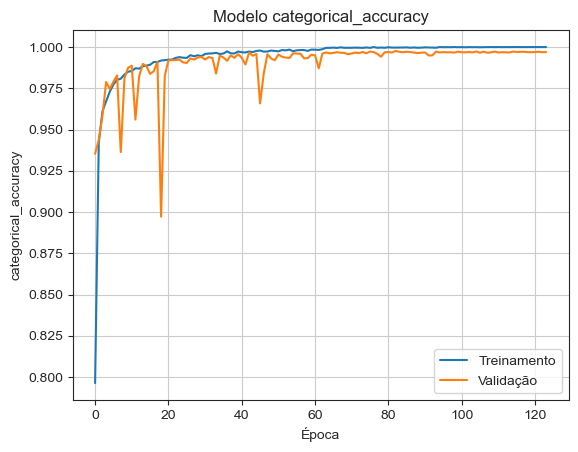

In [25]:
import seaborn as sns

# PLOTTING ACCURACY AND LOSS CURVES 
metric = "categorical_accuracy"

sns.set_style('ticks')

plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])

plt.title("Modelo " + metric)
plt.ylabel(metric)
plt.xlabel("Época")
plt.legend(["Treinamento", "Validação"], loc="best")
plt.grid(True)





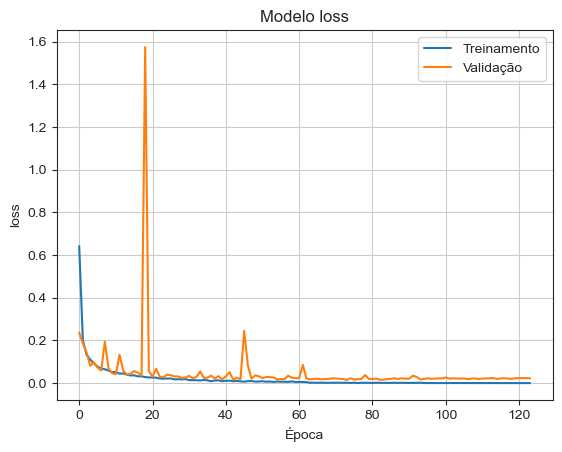

In [26]:
metric = "loss"

sns.set_style('ticks')

plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Modelo " + metric)
plt.ylabel(metric)
plt.xlabel("Época")
plt.legend(["Treinamento", "Validação"], loc="best")
plt.grid(True)

In [27]:
# PREDICTING THE PROBABILITY OF CLASS VECTOR FOR EACH SAMPLE
y_proba = model.predict(x_test)

# PICKING THE HIGHEST VALUE FROM THE PREVIOUS VECTOR
y_pred = np.argmax(y_proba, axis=1)

162/162 [==============================] - 4s 26ms/step


In [28]:
from sklearn.metrics import classification_report

names = ['-CG', '+CG', '-CID', '+CID', 'IC', 'PB', 'RPT', 'CPT']
report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=names, digits=4)
print(report)

              precision    recall  f1-score   support

         -CG     0.9985    0.9971    0.9978      2719
         +CG     0.8173    0.9239    0.8673        92
        -CID     0.9690    0.9690    0.9690       581
        +CID     0.9444    0.9189    0.9315        37
          IC     0.9728    0.9583    0.9655      1677
          PB     0.7447    0.9459    0.8333        37
         RPT     0.8750    0.7000    0.7778        10
         CPT     0.5263    0.7143    0.6061        28

    accuracy                         0.9770      5181
   macro avg     0.8560    0.8909    0.8685      5181
weighted avg     0.9787    0.9770    0.9776      5181



Text(0.5, 43.249999999999986, 'Classe predita')

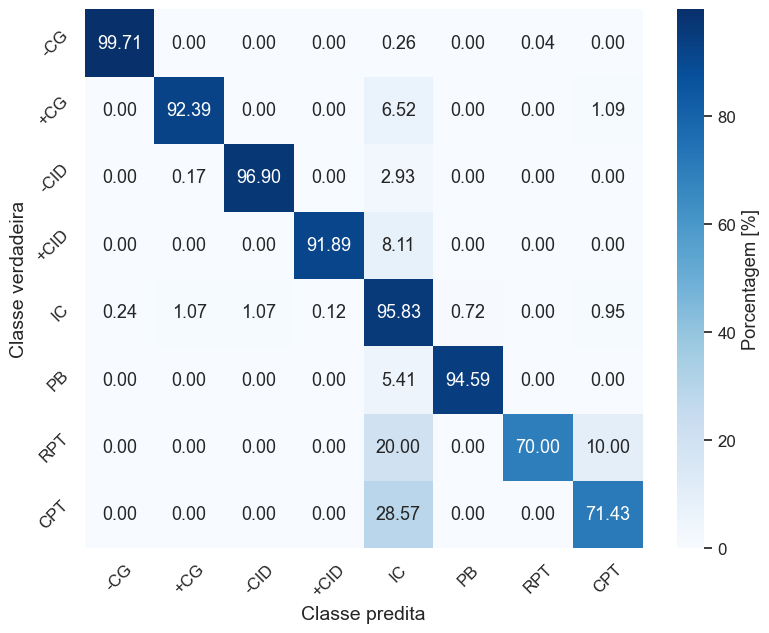

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix

# CONFUSION MATRIX
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(font_scale=1.1)
df_cm = pd.DataFrame(conf_mat_norm, index = names,
                  columns = names)
plt.figure(figsize = (9,7))
sns.heatmap(df_cm*100, annot=True, fmt='.2f', cmap='Blues', 
            annot_kws={"size": 13},
            cbar_kws={'label':'Porcentagem [%]'})

plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.ylabel('Classe verdadeira', fontsize=14)
plt.xlabel('Classe predita', fontsize=14)


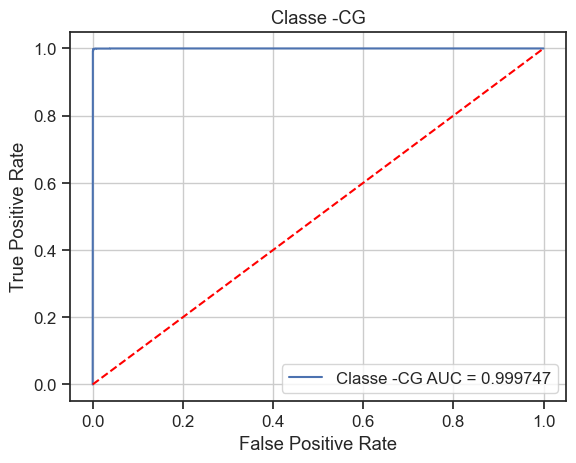

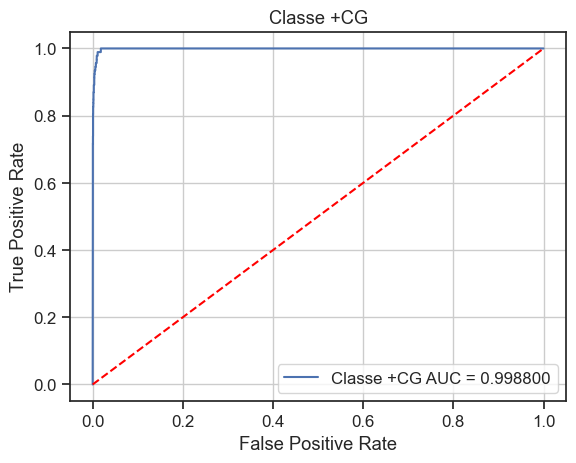

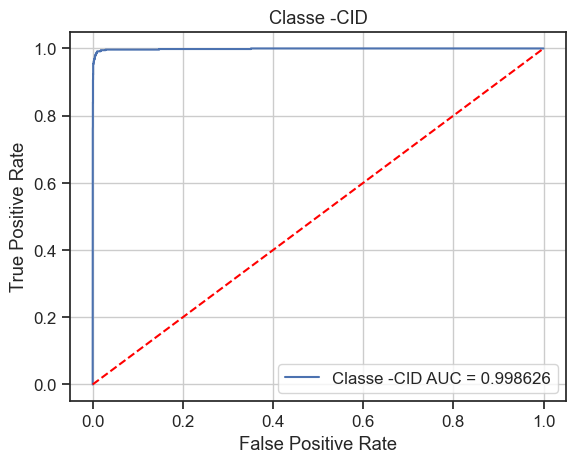

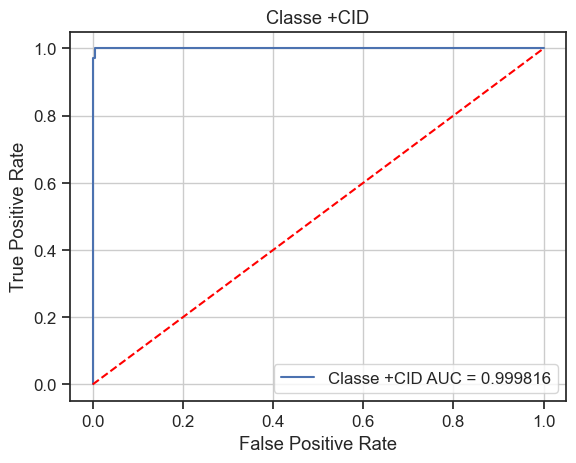

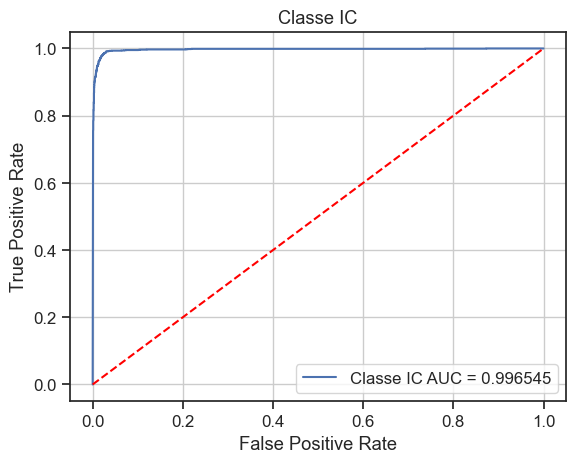

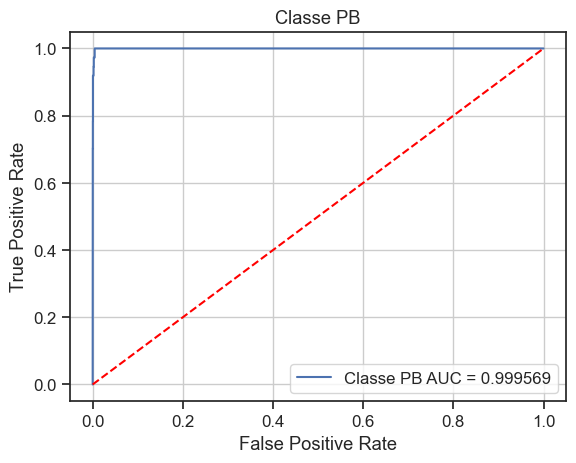

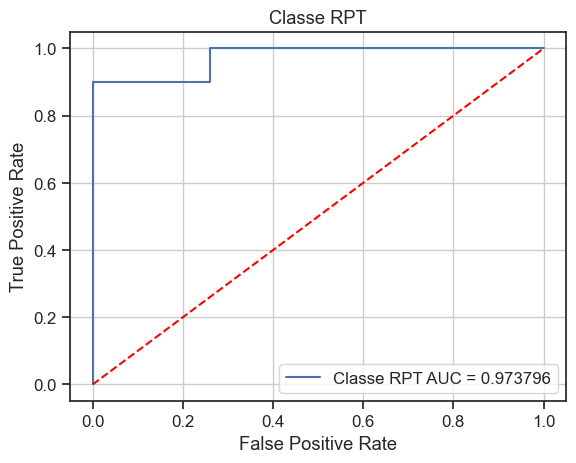

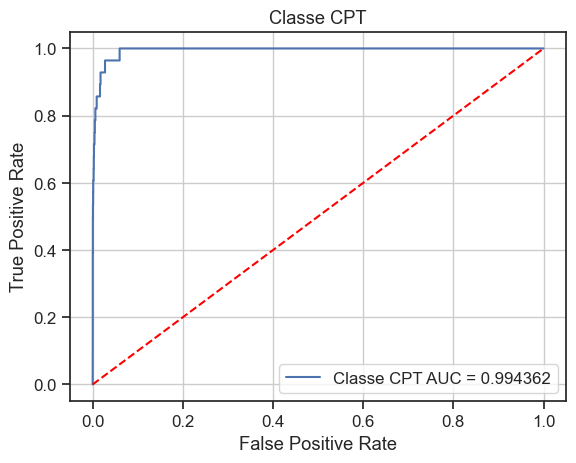

In [30]:
from sklearn import metrics
sns.set_style('ticks')

# ROC CURVES WITH AUC
N_classes = 8

labels = np.argmax(y_test, axis=1)
preds = y_proba

tpr,fpr,roc_auc = ([[]]*N_classes for _ in range(3))


for i in range(N_classes):
    class_names = {0:'-CG', 1:'+CG', 2:'-CID', 3:'+CID', 4:'IC', 5:'PB', 6:'RPT', 7:'CPT'}
    fpr[i], tpr[i], _ = metrics.roc_curve(labels==i, preds[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i],tpr[i])
    plt.legend([f'Classe {class_names[i]} AUC = '+ '%.6f' % roc_auc[i]])
    plt.title(f'Classe {class_names[i]}')
    plt.plot([0, 1], [0, 1], '--', color='red')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.show()